# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 10            
model_seed = 0           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.3390 | Test Loss 2.3121 | accs Train 0.0667 Test 0.0803


Epoch 100/3000: Train Loss 0.0079 | Test Loss 1.4610 | accs Train 1.0000 Test 0.6353


Epoch 200/3000: Train Loss 0.0031 | Test Loss 1.5577 | accs Train 1.0000 Test 0.6361


Epoch 300/3000: Train Loss 0.0019 | Test Loss 1.6129 | accs Train 1.0000 Test 0.6371


Epoch 400/3000: Train Loss 0.0014 | Test Loss 1.6519 | accs Train 1.0000 Test 0.6369


Epoch 500/3000: Train Loss 0.0011 | Test Loss 1.6822 | accs Train 1.0000 Test 0.6372


Epoch 600/3000: Train Loss 0.0009 | Test Loss 1.7068 | accs Train 1.0000 Test 0.6379


Epoch 700/3000: Train Loss 0.0007 | Test Loss 1.7273 | accs Train 1.0000 Test 0.6380


Epoch 800/3000: Train Loss 0.0006 | Test Loss 1.7449 | accs Train 1.0000 Test 0.6381


Epoch 900/3000: Train Loss 0.0006 | Test Loss 1.7602 | accs Train 1.0000 Test 0.6378


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.7738 | accs Train 1.0000 Test 0.6375


Epoch 1100/3000: Train Loss 0.0005 | Test Loss 1.7859 | accs Train 1.0000 Test 0.6375


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.7968 | accs Train 1.0000 Test 0.6376


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.8067 | accs Train 1.0000 Test 0.6375


Epoch 1400/3000: Train Loss 0.0004 | Test Loss 1.8156 | accs Train 1.0000 Test 0.6378


Epoch 1500/3000: Train Loss 0.0003 | Test Loss 1.8238 | accs Train 1.0000 Test 0.6377


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.8314 | accs Train 1.0000 Test 0.6377


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.8383 | accs Train 1.0000 Test 0.6378


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.8448 | accs Train 1.0000 Test 0.6381


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.8508 | accs Train 1.0000 Test 0.6379


Epoch 2000/3000: Train Loss 0.0003 | Test Loss 1.8563 | accs Train 1.0000 Test 0.6379


Epoch 2100/3000: Train Loss 0.0002 | Test Loss 1.8615 | accs Train 1.0000 Test 0.6377


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.8663 | accs Train 1.0000 Test 0.6377


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.8709 | accs Train 1.0000 Test 0.6376


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.8751 | accs Train 1.0000 Test 0.6375


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.8791 | accs Train 1.0000 Test 0.6373


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.8828 | accs Train 1.0000 Test 0.6372


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.8863 | accs Train 1.0000 Test 0.6372


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.8896 | accs Train 1.0000 Test 0.6372


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.8927 | accs Train 1.0000 Test 0.6372


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.8956 | accs Train 1.0000 Test 0.6375
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3157 | Test Loss 2.3120 | accs Train 0.0867 Test 0.0831


Epoch 100/3000: Train Loss 0.1248 | Test Loss 0.4547 | accs Train 0.9833 Test 0.8655


Epoch 200/3000: Train Loss 0.0247 | Test Loss 0.4976 | accs Train 1.0000 Test 0.8672


Epoch 300/3000: Train Loss 0.0114 | Test Loss 0.5365 | accs Train 1.0000 Test 0.8673


Epoch 400/3000: Train Loss 0.0071 | Test Loss 0.5635 | accs Train 1.0000 Test 0.8678


Epoch 500/3000: Train Loss 0.0050 | Test Loss 0.5838 | accs Train 1.0000 Test 0.8677


Epoch 600/3000: Train Loss 0.0038 | Test Loss 0.5999 | accs Train 1.0000 Test 0.8678


Epoch 700/3000: Train Loss 0.0031 | Test Loss 0.6132 | accs Train 1.0000 Test 0.8671


Epoch 800/3000: Train Loss 0.0026 | Test Loss 0.6244 | accs Train 1.0000 Test 0.8671


Epoch 900/3000: Train Loss 0.0022 | Test Loss 0.6341 | accs Train 1.0000 Test 0.8674


Epoch 1000/3000: Train Loss 0.0019 | Test Loss 0.6425 | accs Train 1.0000 Test 0.8678


Epoch 1100/3000: Train Loss 0.0017 | Test Loss 0.6500 | accs Train 1.0000 Test 0.8678


Epoch 1200/3000: Train Loss 0.0015 | Test Loss 0.6568 | accs Train 1.0000 Test 0.8674


Epoch 1300/3000: Train Loss 0.0014 | Test Loss 0.6628 | accs Train 1.0000 Test 0.8677


Epoch 1400/3000: Train Loss 0.0013 | Test Loss 0.6683 | accs Train 1.0000 Test 0.8678


Epoch 1500/3000: Train Loss 0.0012 | Test Loss 0.6733 | accs Train 1.0000 Test 0.8679


Epoch 1600/3000: Train Loss 0.0011 | Test Loss 0.6779 | accs Train 1.0000 Test 0.8679


Epoch 1700/3000: Train Loss 0.0010 | Test Loss 0.6822 | accs Train 1.0000 Test 0.8680


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.6861 | accs Train 1.0000 Test 0.8678


Epoch 1900/3000: Train Loss 0.0009 | Test Loss 0.6898 | accs Train 1.0000 Test 0.8677


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.6932 | accs Train 1.0000 Test 0.8678


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6963 | accs Train 1.0000 Test 0.8678


Epoch 2200/3000: Train Loss 0.0008 | Test Loss 0.6993 | accs Train 1.0000 Test 0.8677


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.7021 | accs Train 1.0000 Test 0.8677


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.7047 | accs Train 1.0000 Test 0.8676


Epoch 2500/3000: Train Loss 0.0007 | Test Loss 0.7071 | accs Train 1.0000 Test 0.8677


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.7095 | accs Train 1.0000 Test 0.8677


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.7116 | accs Train 1.0000 Test 0.8677


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.7137 | accs Train 1.0000 Test 0.8679


Epoch 2900/3000: Train Loss 0.0006 | Test Loss 0.7156 | accs Train 1.0000 Test 0.8680


Epoch 3000/3000: Train Loss 0.0006 | Test Loss 0.7174 | accs Train 1.0000 Test 0.8680
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3141 | Test Loss 2.3119 | accs Train 0.0755 Test 0.0823


Epoch 100/3000: Train Loss 0.2873 | Test Loss 0.3684 | accs Train 0.9140 Test 0.8931


Epoch 200/3000: Train Loss 0.1302 | Test Loss 0.3310 | accs Train 0.9695 Test 0.9024


Epoch 300/3000: Train Loss 0.0644 | Test Loss 0.3429 | accs Train 0.9940 Test 0.9037


Epoch 400/3000: Train Loss 0.0350 | Test Loss 0.3624 | accs Train 0.9985 Test 0.9041


Epoch 500/3000: Train Loss 0.0214 | Test Loss 0.3810 | accs Train 0.9995 Test 0.9047


Epoch 600/3000: Train Loss 0.0145 | Test Loss 0.3969 | accs Train 1.0000 Test 0.9036


Epoch 700/3000: Train Loss 0.0106 | Test Loss 0.4104 | accs Train 1.0000 Test 0.9042


Epoch 800/3000: Train Loss 0.0082 | Test Loss 0.4219 | accs Train 1.0000 Test 0.9042


Epoch 900/3000: Train Loss 0.0066 | Test Loss 0.4318 | accs Train 1.0000 Test 0.9047


Epoch 1000/3000: Train Loss 0.0055 | Test Loss 0.4404 | accs Train 1.0000 Test 0.9051


Epoch 1100/3000: Train Loss 0.0047 | Test Loss 0.4478 | accs Train 1.0000 Test 0.9057


Epoch 1200/3000: Train Loss 0.0040 | Test Loss 0.4545 | accs Train 1.0000 Test 0.9058


Epoch 1300/3000: Train Loss 0.0036 | Test Loss 0.4604 | accs Train 1.0000 Test 0.9056


Epoch 1400/3000: Train Loss 0.0032 | Test Loss 0.4657 | accs Train 1.0000 Test 0.9057


Epoch 1500/3000: Train Loss 0.0029 | Test Loss 0.4705 | accs Train 1.0000 Test 0.9057


Epoch 1600/3000: Train Loss 0.0026 | Test Loss 0.4749 | accs Train 1.0000 Test 0.9055


Epoch 1700/3000: Train Loss 0.0024 | Test Loss 0.4789 | accs Train 1.0000 Test 0.9055


Epoch 1800/3000: Train Loss 0.0022 | Test Loss 0.4826 | accs Train 1.0000 Test 0.9057


Epoch 1900/3000: Train Loss 0.0020 | Test Loss 0.4861 | accs Train 1.0000 Test 0.9054


Epoch 2000/3000: Train Loss 0.0019 | Test Loss 0.4893 | accs Train 1.0000 Test 0.9053


Epoch 2100/3000: Train Loss 0.0018 | Test Loss 0.4922 | accs Train 1.0000 Test 0.9052


Epoch 2200/3000: Train Loss 0.0017 | Test Loss 0.4950 | accs Train 1.0000 Test 0.9053


Epoch 2300/3000: Train Loss 0.0016 | Test Loss 0.4975 | accs Train 1.0000 Test 0.9053


Epoch 2400/3000: Train Loss 0.0015 | Test Loss 0.4999 | accs Train 1.0000 Test 0.9055


Epoch 2500/3000: Train Loss 0.0014 | Test Loss 0.5021 | accs Train 1.0000 Test 0.9056


Epoch 2600/3000: Train Loss 0.0014 | Test Loss 0.5042 | accs Train 1.0000 Test 0.9056


Epoch 2700/3000: Train Loss 0.0013 | Test Loss 0.5062 | accs Train 1.0000 Test 0.9055


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.5081 | accs Train 1.0000 Test 0.9057


Epoch 2900/3000: Train Loss 0.0012 | Test Loss 0.5098 | accs Train 1.0000 Test 0.9056


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.5115 | accs Train 1.0000 Test 0.9057
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3149 | Test Loss 2.3119 | accs Train 0.0752 Test 0.0824


Epoch 100/3000: Train Loss 0.3157 | Test Loss 0.3517 | accs Train 0.9090 Test 0.8990


Epoch 200/3000: Train Loss 0.2085 | Test Loss 0.2850 | accs Train 0.9423 Test 0.9195


Epoch 300/3000: Train Loss 0.1542 | Test Loss 0.2608 | accs Train 0.9572 Test 0.9264


Epoch 400/3000: Train Loss 0.1143 | Test Loss 0.2463 | accs Train 0.9723 Test 0.9304


Epoch 500/3000: Train Loss 0.0844 | Test Loss 0.2381 | accs Train 0.9815 Test 0.9337


Epoch 600/3000: Train Loss 0.0623 | Test Loss 0.2339 | accs Train 0.9890 Test 0.9358


Epoch 700/3000: Train Loss 0.0463 | Test Loss 0.2328 | accs Train 0.9927 Test 0.9372


Epoch 800/3000: Train Loss 0.0348 | Test Loss 0.2338 | accs Train 0.9952 Test 0.9386


Epoch 900/3000: Train Loss 0.0266 | Test Loss 0.2359 | accs Train 0.9983 Test 0.9395


Epoch 1000/3000: Train Loss 0.0209 | Test Loss 0.2385 | accs Train 0.9992 Test 0.9400


Epoch 1100/3000: Train Loss 0.0168 | Test Loss 0.2414 | accs Train 0.9993 Test 0.9403


Epoch 1200/3000: Train Loss 0.0138 | Test Loss 0.2443 | accs Train 0.9995 Test 0.9409


Epoch 1300/3000: Train Loss 0.0115 | Test Loss 0.2473 | accs Train 0.9997 Test 0.9418


Epoch 1400/3000: Train Loss 0.0097 | Test Loss 0.2501 | accs Train 0.9998 Test 0.9420


Epoch 1500/3000: Train Loss 0.0083 | Test Loss 0.2527 | accs Train 0.9998 Test 0.9421


Epoch 1600/3000: Train Loss 0.0073 | Test Loss 0.2551 | accs Train 0.9998 Test 0.9421


Epoch 1700/3000: Train Loss 0.0064 | Test Loss 0.2574 | accs Train 1.0000 Test 0.9422


Epoch 1800/3000: Train Loss 0.0057 | Test Loss 0.2595 | accs Train 1.0000 Test 0.9425


Epoch 1900/3000: Train Loss 0.0051 | Test Loss 0.2615 | accs Train 1.0000 Test 0.9426


Epoch 2000/3000: Train Loss 0.0046 | Test Loss 0.2634 | accs Train 1.0000 Test 0.9426


Epoch 2100/3000: Train Loss 0.0042 | Test Loss 0.2652 | accs Train 1.0000 Test 0.9429


Epoch 2200/3000: Train Loss 0.0039 | Test Loss 0.2668 | accs Train 1.0000 Test 0.9431


Epoch 2300/3000: Train Loss 0.0036 | Test Loss 0.2684 | accs Train 1.0000 Test 0.9432


Epoch 2400/3000: Train Loss 0.0033 | Test Loss 0.2698 | accs Train 1.0000 Test 0.9431


Epoch 2500/3000: Train Loss 0.0031 | Test Loss 0.2712 | accs Train 1.0000 Test 0.9430


Epoch 2600/3000: Train Loss 0.0029 | Test Loss 0.2725 | accs Train 1.0000 Test 0.9431


Epoch 2700/3000: Train Loss 0.0027 | Test Loss 0.2737 | accs Train 1.0000 Test 0.9433


Epoch 2800/3000: Train Loss 0.0026 | Test Loss 0.2749 | accs Train 1.0000 Test 0.9433


Epoch 2900/3000: Train Loss 0.0025 | Test Loss 0.2760 | accs Train 1.0000 Test 0.9432


Epoch 3000/3000: Train Loss 0.0023 | Test Loss 0.2770 | accs Train 1.0000 Test 0.9434
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3159 | Test Loss 2.3119 | accs Train 0.0747 Test 0.0826


Epoch 100/3000: Train Loss 0.3524 | Test Loss 0.3455 | accs Train 0.8982 Test 0.9013


Epoch 200/3000: Train Loss 0.2606 | Test Loss 0.2686 | accs Train 0.9238 Test 0.9221


Epoch 300/3000: Train Loss 0.2136 | Test Loss 0.2321 | accs Train 0.9390 Test 0.9334


Epoch 400/3000: Train Loss 0.1776 | Test Loss 0.2042 | accs Train 0.9498 Test 0.9414


Epoch 500/3000: Train Loss 0.1487 | Test Loss 0.1822 | accs Train 0.9587 Test 0.9480


Epoch 600/3000: Train Loss 0.1255 | Test Loss 0.1655 | accs Train 0.9656 Test 0.9529


Epoch 700/3000: Train Loss 0.1065 | Test Loss 0.1528 | accs Train 0.9715 Test 0.9557


Epoch 800/3000: Train Loss 0.0908 | Test Loss 0.1431 | accs Train 0.9764 Test 0.9583


Epoch 900/3000: Train Loss 0.0777 | Test Loss 0.1355 | accs Train 0.9806 Test 0.9596


Epoch 1000/3000: Train Loss 0.0667 | Test Loss 0.1297 | accs Train 0.9843 Test 0.9614


Epoch 1100/3000: Train Loss 0.0574 | Test Loss 0.1252 | accs Train 0.9873 Test 0.9619


Epoch 1200/3000: Train Loss 0.0495 | Test Loss 0.1217 | accs Train 0.9896 Test 0.9632


Epoch 1300/3000: Train Loss 0.0428 | Test Loss 0.1191 | accs Train 0.9913 Test 0.9637


Epoch 1400/3000: Train Loss 0.0370 | Test Loss 0.1170 | accs Train 0.9928 Test 0.9642


Epoch 1500/3000: Train Loss 0.0321 | Test Loss 0.1154 | accs Train 0.9944 Test 0.9653


Epoch 1600/3000: Train Loss 0.0280 | Test Loss 0.1142 | accs Train 0.9954 Test 0.9663


Epoch 1700/3000: Train Loss 0.0244 | Test Loss 0.1134 | accs Train 0.9967 Test 0.9667


Epoch 1800/3000: Train Loss 0.0214 | Test Loss 0.1129 | accs Train 0.9972 Test 0.9672


Epoch 1900/3000: Train Loss 0.0189 | Test Loss 0.1125 | accs Train 0.9981 Test 0.9671


Epoch 2000/3000: Train Loss 0.0167 | Test Loss 0.1124 | accs Train 0.9987 Test 0.9676


Epoch 2100/3000: Train Loss 0.0149 | Test Loss 0.1124 | accs Train 0.9989 Test 0.9679


Epoch 2200/3000: Train Loss 0.0133 | Test Loss 0.1125 | accs Train 0.9991 Test 0.9680


Epoch 2300/3000: Train Loss 0.0120 | Test Loss 0.1127 | accs Train 0.9994 Test 0.9684


Epoch 2400/3000: Train Loss 0.0108 | Test Loss 0.1130 | accs Train 0.9995 Test 0.9685


Epoch 2500/3000: Train Loss 0.0098 | Test Loss 0.1133 | accs Train 0.9995 Test 0.9686


Epoch 2600/3000: Train Loss 0.0090 | Test Loss 0.1137 | accs Train 0.9997 Test 0.9688


Epoch 2700/3000: Train Loss 0.0082 | Test Loss 0.1141 | accs Train 0.9997 Test 0.9688


Epoch 2800/3000: Train Loss 0.0076 | Test Loss 0.1145 | accs Train 0.9998 Test 0.9685


Epoch 2900/3000: Train Loss 0.0070 | Test Loss 0.1149 | accs Train 0.9998 Test 0.9684


Epoch 3000/3000: Train Loss 0.0065 | Test Loss 0.1153 | accs Train 0.9999 Test 0.9687
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3155 | Test Loss 2.3119 | accs Train 0.0739 Test 0.0825


Epoch 100/3000: Train Loss 0.3617 | Test Loss 0.3437 | accs Train 0.8957 Test 0.9010


Epoch 200/3000: Train Loss 0.2751 | Test Loss 0.2647 | accs Train 0.9204 Test 0.9229


Epoch 300/3000: Train Loss 0.2314 | Test Loss 0.2260 | accs Train 0.9332 Test 0.9344


Epoch 400/3000: Train Loss 0.1977 | Test Loss 0.1957 | accs Train 0.9436 Test 0.9425


Epoch 500/3000: Train Loss 0.1707 | Test Loss 0.1713 | accs Train 0.9511 Test 0.9492


Epoch 600/3000: Train Loss 0.1491 | Test Loss 0.1521 | accs Train 0.9580 Test 0.9543


Epoch 700/3000: Train Loss 0.1316 | Test Loss 0.1369 | accs Train 0.9631 Test 0.9599


Epoch 800/3000: Train Loss 0.1173 | Test Loss 0.1249 | accs Train 0.9671 Test 0.9628


Epoch 900/3000: Train Loss 0.1053 | Test Loss 0.1154 | accs Train 0.9710 Test 0.9655


Epoch 1000/3000: Train Loss 0.0952 | Test Loss 0.1076 | accs Train 0.9737 Test 0.9679


Epoch 1100/3000: Train Loss 0.0865 | Test Loss 0.1013 | accs Train 0.9762 Test 0.9690


Epoch 1200/3000: Train Loss 0.0790 | Test Loss 0.0960 | accs Train 0.9783 Test 0.9705


Epoch 1300/3000: Train Loss 0.0723 | Test Loss 0.0915 | accs Train 0.9799 Test 0.9718


Epoch 1400/3000: Train Loss 0.0665 | Test Loss 0.0877 | accs Train 0.9817 Test 0.9733


Epoch 1500/3000: Train Loss 0.0613 | Test Loss 0.0845 | accs Train 0.9833 Test 0.9740


Epoch 1600/3000: Train Loss 0.0566 | Test Loss 0.0817 | accs Train 0.9849 Test 0.9750


Epoch 1700/3000: Train Loss 0.0524 | Test Loss 0.0794 | accs Train 0.9864 Test 0.9755


Epoch 1800/3000: Train Loss 0.0486 | Test Loss 0.0773 | accs Train 0.9876 Test 0.9756


Epoch 1900/3000: Train Loss 0.0452 | Test Loss 0.0755 | accs Train 0.9885 Test 0.9764


Epoch 2000/3000: Train Loss 0.0421 | Test Loss 0.0740 | accs Train 0.9895 Test 0.9772


Epoch 2100/3000: Train Loss 0.0392 | Test Loss 0.0726 | accs Train 0.9904 Test 0.9776


Epoch 2200/3000: Train Loss 0.0366 | Test Loss 0.0715 | accs Train 0.9912 Test 0.9781


Epoch 2300/3000: Train Loss 0.0342 | Test Loss 0.0705 | accs Train 0.9920 Test 0.9785


Epoch 2400/3000: Train Loss 0.0319 | Test Loss 0.0696 | accs Train 0.9927 Test 0.9789


Epoch 2500/3000: Train Loss 0.0299 | Test Loss 0.0689 | accs Train 0.9934 Test 0.9791


Epoch 2600/3000: Train Loss 0.0280 | Test Loss 0.0682 | accs Train 0.9942 Test 0.9791


Epoch 2700/3000: Train Loss 0.0263 | Test Loss 0.0677 | accs Train 0.9947 Test 0.9794


Epoch 2800/3000: Train Loss 0.0246 | Test Loss 0.0672 | accs Train 0.9952 Test 0.9795


Epoch 2900/3000: Train Loss 0.0231 | Test Loss 0.0668 | accs Train 0.9957 Test 0.9796


Epoch 3000/3000: Train Loss 0.0217 | Test Loss 0.0664 | accs Train 0.9961 Test 0.9796
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.8956 | accs: 0.6375
 540 samples | Test Loss: 0.7174 | accs: 0.8680
1940 samples | Test Loss: 0.5115 | accs: 0.9057
5940 samples | Test Loss: 0.2770 | accs: 0.9434
19940 samples | Test Loss: 0.1153 | accs: 0.9687
59940 samples | Test Loss: 0.0664 | accs: 0.9796

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0013 | accs: 1.0000
 Model 5940 | Train Loss: 0.0030 | accs: 1.0000
 Model 19940 | Train Loss: 0.0070 | accs: 1.0000
 Model 59940 | Train Loss: 0.0130 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.6998 | accs: 0.6683
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0012 | accs: 1.0000
 Model 5940 | Train Loss: 0.0026 | accs: 1.0000
 Model 19940 | Train Loss: 0.0064 | accs: 1.0000
 Model 59940 | Trai

### Model + Data Specific Verification

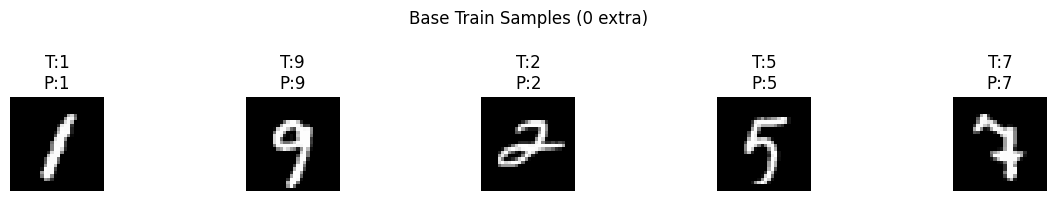

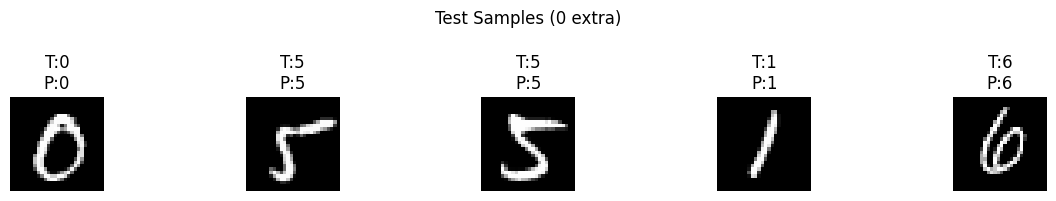

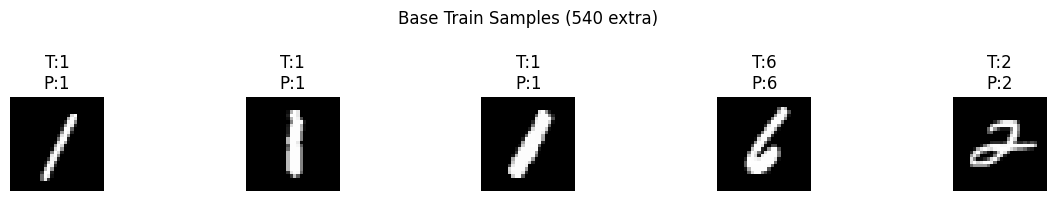

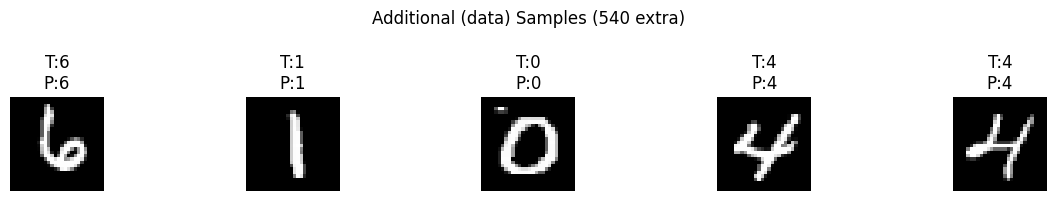

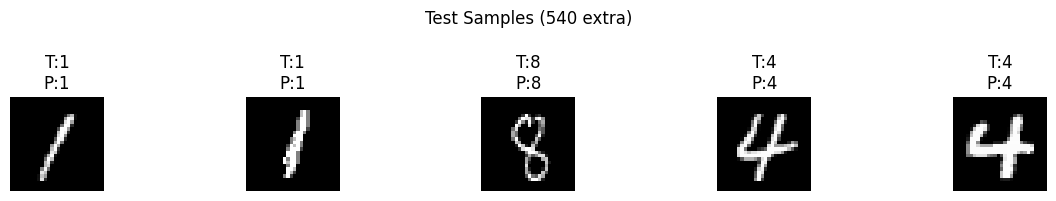

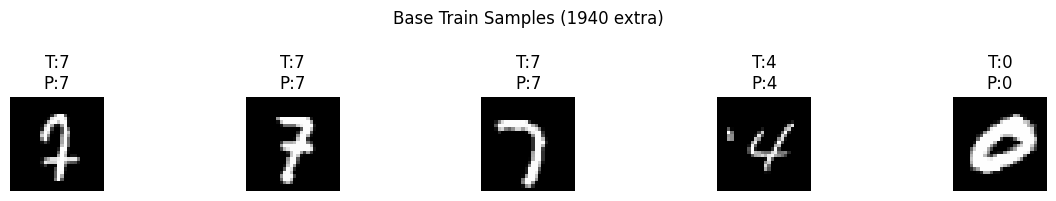

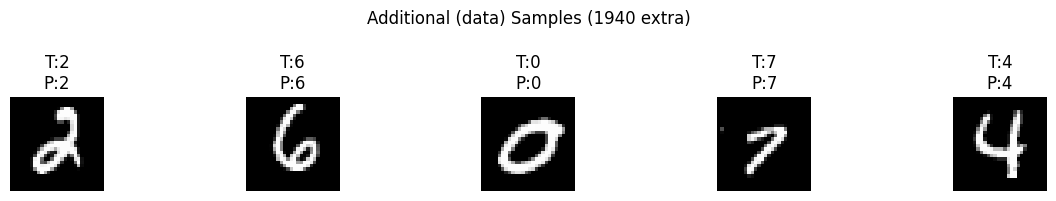

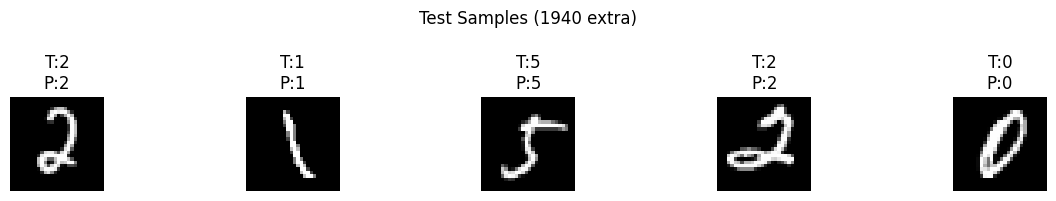

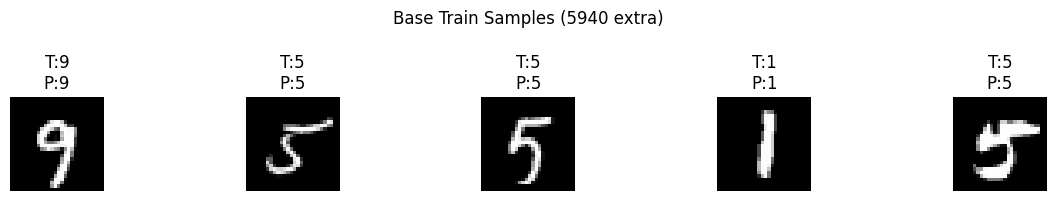

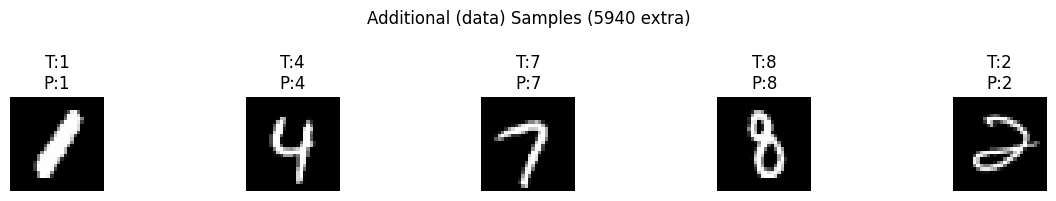

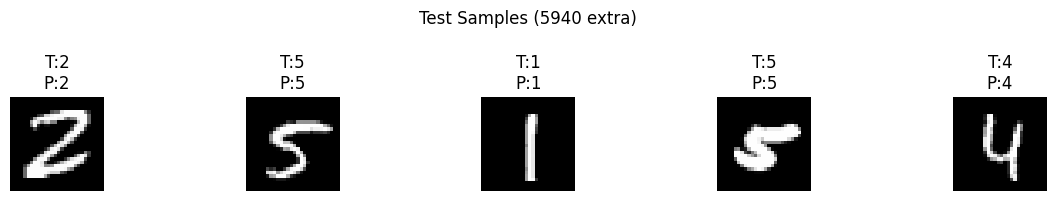

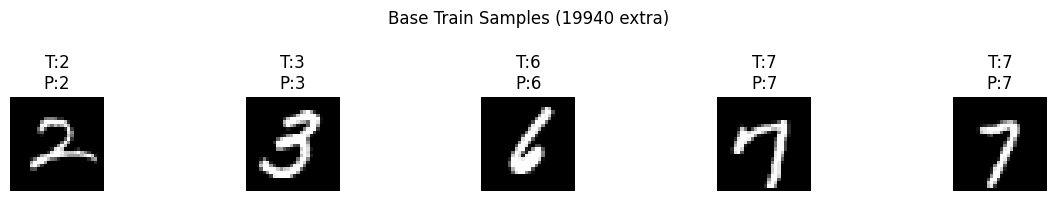

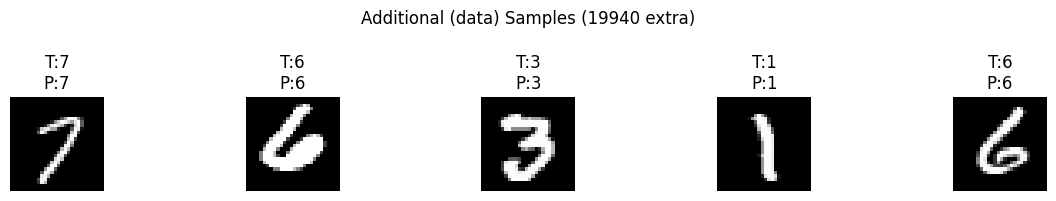

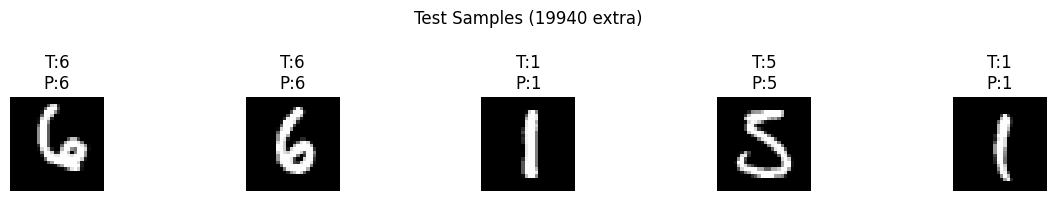

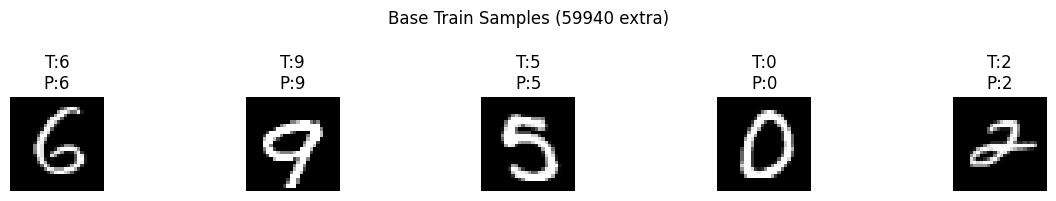

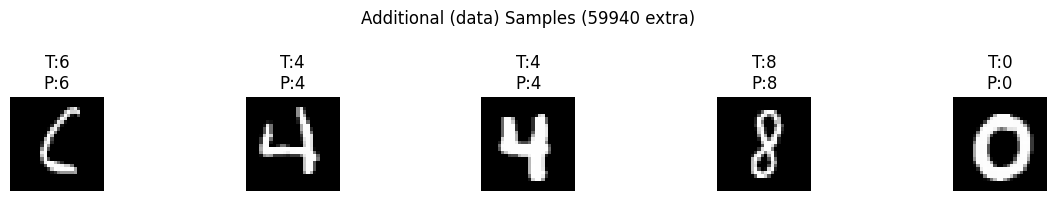

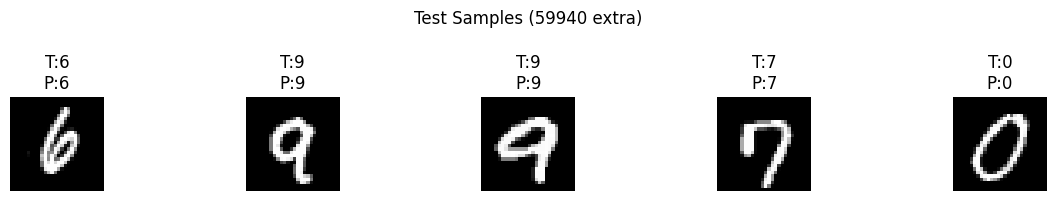

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
